# 1-03 Inferential statistics for acoustics

## Goals:
- Test the effect of speaking rate on vowel formants
- Test the effect of consonant context on vowel formants
- Test the interaction between the two

## Procedure:
- (1) Descriptive analysis
- (2) Inferential statistics
- (3) Summary plots

In [1]:
# Basic
import os
import re
import pickle
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm

# Visualization
from IPython.display import Image, HTML, display
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# Custom
from tools.utils import *
from tools.plots import *
from tools.postproc import *
from tools.guided_pca import GuidedPCA

rand_seed = 0

## R setup

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
# Stat
library(stats)
library(lme4)
library(emmeans)

# Plotting
library(ggplot2)
library(ggeffects)
library(ggpubr)
library(sjPlot)

R[write to console]: Loading required package: Matrix

R[write to console]: Registered S3 methods overwritten by 'car':
  method                          from
  influence.merMod                lme4
  cooks.distance.influence.merMod lme4
  dfbeta.influence.merMod         lme4
  dfbetas.influence.merMod        lme4

R[write to console]: Learn more about sjPlot with 'browseVignettes("sjPlot")'.



## Settings

In [4]:
use_mel = True

# --- data param
vowel_target_file = 'vowel_targets.csv'
grand_mean_file = 'grand_means.csv'
pca_regular_file = 'pca_regular.pkl'
pca_guided_file = 'pca_guided.pkl'
zscore_file = 'zscore.pkl'
data_processed = 'data_processed'
stat_file = 'data_stat.csv'

plot_dir = 'stat_analysis'

# --- hyperparam
rate_list = ['N', 'F']
acous_col = ['F1', 'F2']
artic_col = ['TRx','TRz','TBx','TBz','TTx','TTz','JAWx','JAWz','ULx','ULz','LLx','LLz']
if use_mel:
    acous_col = [c + '_mel' for c in acous_col]
acous_col_norm = [re.sub('_mel', '_norm', ac) for ac in acous_col]
artic_col_norm = [ac+'_norm' for ac in artic_col]
num_points = 5
vowel_mid_point = 0.5 # 0~1
corner_vowels = ['IY1', 'AE1', 'AA1', 'UW1']
vowel_label = ['i', 'ɪ', 'ɛ', 'ʌ', 'ɔ', 'ɑ', 'æ', 'ʊ', 'u']
vowel2ipa = {
    'IY1': 'i',
    'IH1': 'ɪ',
    'EH1': 'ɛ',
    'AO1': 'ʌ',
    'AH1': 'ɔ',
    'AA1': 'ɑ',
    'AE1': 'æ',
    'UH1': 'ʊ',
    'UW1': 'u',
}
num_pca = 3
const_list = ['P','B','T','D','S','K','G','HH']
poa_list = ['bilabial','alveolar','velar','fricative']

## Data preparation

In [5]:
D_raw = pd.read_csv(os.path.join(data_processed, stat_file))
D_raw.drop(D_raw.columns[0], axis=1, inplace=True);

In [6]:
D_raw.tail()

,Token,FileID,Speaker,Block,Rate,Sent,Rep,Word,PreVowel,Vowel,...,JAWz_norm,ULx_norm,ULz_norm,LLx_norm,LLz_norm,PreVowelPOA,PostVowelPOA,Pronunciation,Tag,PlaceOfArticulation
138570,52079,M04_B12_S60_R01_N,M04,12,N,S60,1,COME,K,AH1,...,-0.087879,0.132426,0.154095,-0.023946,-0.190213,velar,sp,K-AH1-M,C-V1-C,velar-tongue-bilabial
138571,52079,M04_B12_S60_R01_N,M04,12,N,S60,1,COME,K,AH1,...,-0.090710,0.149578,0.144148,-0.016002,-0.164873,velar,sp,K-AH1-M,C-V1-C,velar-tongue-bilabial
138572,52079,M04_B12_S60_R01_N,M04,12,N,S60,1,COME,K,AH1,...,-0.062283,0.127111,0.047193,0.040988,-0.027688,velar,sp,K-AH1-M,C-V1-C,velar-tongue-bilabial
138573,52079,M04_B12_S60_R01_N,M04,12,N,S60,1,COME,K,AH1,...,-0.035660,0.105324,-0.037390,0.069666,0.076274,velar,sp,K-AH1-M,C-V1-C,velar-tongue-bilabial
138574,52079,M04_B12_S60_R01_N,M04,12,N,S60,1,COME,K,AH1,...,0.032341,0.138669,-0.149052,0.134113,0.268623,velar,sp,K-AH1-M,C-V1-C,velar-tongue-bilabial


### Apply preceding place of articulation filter
- choosing the mid-point only
- choosing the selected pre-vowel consonants

In [7]:
D = D_raw.loc[D_raw.PreVowel.isin(const_list)]
# D = D.loc[D.PreVowelPOA.isin(poa_list)]
D = D.loc[D.TimeAt == 0.5].reset_index(drop=True)
D.tail()

,Token,FileID,Speaker,Block,Rate,Sent,Rep,Word,PreVowel,Vowel,...,JAWz_norm,ULx_norm,ULz_norm,LLx_norm,LLz_norm,PreVowelPOA,PostVowelPOA,Pronunciation,Tag,PlaceOfArticulation
14314,52066,M04_B12_S59_R01_N,M04,12,N,S59,1,CALLED,K,AO1,...,-0.125473,0.142872,0.000056,0.031536,-0.164536,velar,sp,K-AO1-L-D,C-VV1-C-C,velar-tongue-lateral-alveolar
14315,52072,M04_B12_S60_R01_F,M04,12,F,S60,1,BELL,B,EH1,...,-0.119723,0.029233,0.065437,-0.024716,-0.117147,bilabial,sp,B-EH1-L,C-V1-C,bilabial-tongue-lateral
14316,52073,M04_B12_S60_R01_F,M04,12,F,S60,1,COME,K,AH1,...,0.000548,0.110118,-0.142988,0.094059,0.212037,velar,sp,K-AH1-M,C-V1-C,velar-tongue-bilabial
14317,52078,M04_B12_S60_R01_N,M04,12,N,S60,1,BELL,B,EH1,...,-0.239463,0.017077,0.122421,-0.135599,-0.336697,bilabial,sp,B-EH1-L,C-V1-C,bilabial-tongue-lateral
14318,52079,M04_B12_S60_R01_N,M04,12,N,S60,1,COME,K,AH1,...,-0.062283,0.127111,0.047193,0.040988,-0.027688,velar,sp,K-AH1-M,C-V1-C,velar-tongue-bilabial


In [8]:
D.PreVowelPOA.value_counts()

alveolar      6762
bilabial      3502
velar         2413
pharyngeal    1642
Name: PreVowelPOA, dtype: int64

In [9]:
# Get data info
spkr_list = sorted(D.Speaker.unique().tolist())
word_list = sorted(D.Word.unique().tolist())
vowel_list_all = sorted(D.Vowel.unique().tolist())  # all vowels
# vowel_list = ["IY1", "IH1", "EH1", "AE1", "AA1", "AH1", "AO1", "UH1", "UW1"]
vowel_list = ["IY1", "IH1", "EH1", "AE1", "AA1", "AH1", "AO1", "UW1"]
D = D.loc[D.Vowel.isin(vowel_list)].reset_index(drop=True)
time_list = D.TimeAt.unique().tolist()
block_list = sorted(D.Block.unique().tolist())
print("Speaker:", spkr_list)
print("Words: num=", len(word_list))
print("Vowels (all):", vowel_list_all)
print("Vowels (selected):", vowel_list)  # 9 vowels selected
print("Blocks:", block_list)
print('Times:', time_list)

Speaker: ['F01', 'F02', 'F03', 'F04', 'M01', 'M02', 'M03', 'M04']
Words: num= 577
Vowels (all): ['AA1', 'AE1', 'AH1', 'AO1', 'EH1', 'IH1', 'IY1', 'UH1', 'UW1']
Vowels (selected): ['IY1', 'IH1', 'EH1', 'AE1', 'AA1', 'AH1', 'AO1', 'UW1']
Blocks: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Times: [0.5]


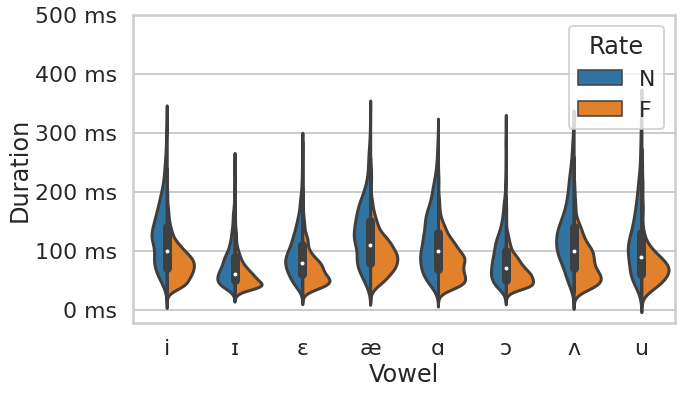

In [10]:
# Overall vowel duration (checking only mid-point)
which_time = 0.5
fig, ax = duration_by_condition_boxplot(
    D[D.TimeAt == which_time],
    duration_col="Duration",
    hue="Rate", hue_order=['N','F'],
    condition_col="Vowel",
    condition_list=vowel_list,
    vowel2ipa=vowel2ipa,
)
# ax.set_title("Overall vowel duration by vowel per rate", fontsize=30, y=1.02);

In [11]:
# Define helper functions
def _plot_dur_vowels(df, which_spkr, which_time, custom_vowels):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5), facecolor='white')
    ax1 = plot_duration(ax1, df, which_spkr, custom_vowels, vowel2ipa)
    ax2 = plot_F1F2_df(ax2, df.loc[(df.Speaker==which_spkr)&(df.Rate=='N')&(df.TimeAt==which_time)], 
                       vowel_col='Vowel', vowel_list=custom_vowels, 
                       F1_col='F1_mel', F2_col='F2_mel', vowel2ipa=vowel2ipa)
    ax3 = plot_F1F2_df(ax3, df.loc[(df.Speaker==which_spkr)&(df.Rate=='F')&(df.TimeAt==which_time)], 
                       vowel_col='Vowel', vowel_list=custom_vowels, 
                       F1_col='F1_mel', F2_col='F2_mel', vowel2ipa=vowel2ipa)
    # Titles
    ax1.set_title('Duration', fontsize=25);
    ax2.set_title('Normal rate', fontsize=25);
    ax3.set_title('Fast rate', fontsize=25);
    fig.suptitle(f'Speaker: {which_spkr}', y=0.9);
    fig.tight_layout()
    return fig, [ax1, ax2, ax3]

def _plot_dur_vowel_spaces(df, which_spkr, which_time, custom_vowels, 
                           center_stat='median',
                           show_title=True, 
                           ax2_title='Vowel space (ellipses)',
                           ax3_title='Vowel space (quadrilateral)'):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5), facecolor='white')
    # --- Duration plot
    ax1 = plot_duration(ax1, df.loc[df.Speaker==which_spkr], which_spkr, custom_vowels, vowel2ipa)
    # --- Ellipse plot
    ax2 = plot_F1F2_df(ax2, df.loc[(df.Speaker==which_spkr)&(df.Rate=='N')&(df.TimeAt==which_time)], 
                       vowel_col='Vowel', vowel_list=custom_vowels, 
                       F1_col='F1_mel', F2_col='F2_mel', vowel2ipa=vowel2ipa, 
                       center_only=False,
                       ellipse_only=True,
                       ellipse_linestyle='-',
                      )
    ax2 = plot_F1F2_df(ax2, df.loc[(df.Speaker==which_spkr)&(df.Rate=='F')&(df.TimeAt==which_time)], 
                       vowel_col='Vowel', vowel_list=custom_vowels, 
                       F1_col='F1_mel', F2_col='F2_mel', show_label=False, 
                       center_only=False,
                       ellipse_only=True,
                       ellipse_linestyle='--',
                      )
    # Prettify
    l1, = ax2.plot([], [], 'k-', linewidth=2)
    l2, = ax2.plot([], [], 'k--', linewidth=2)
    ax2.legend([l1, l2], ['N','F'], fontsize=10)

    # --- Line plot
    ax3 = plot_F1F2_df(ax3, df.loc[(df.Speaker==which_spkr)&(df.Rate=='N')&(df.TimeAt==which_time)], 
                       vowel_col='Vowel', vowel_list=custom_vowels, 
                       F1_col='F1_mel', F2_col='F2_mel', vowel2ipa=vowel2ipa, 
                       center_only=center_stat,
                       connected_linestyle='-'
                      )
    ax3 = plot_F1F2_df(ax3, df.loc[(df.Speaker==which_spkr)&(df.Rate=='F')&(df.TimeAt==which_time)], 
                       vowel_col='Vowel', vowel_list=custom_vowels, 
                       F1_col='F1_mel', F2_col='F2_mel', show_label=False, 
                       center_only=center_stat,
                       connected_linestyle='--'
                      )
    # Prettify
    l1, = ax3.plot([], [], 'k-', linewidth=2)
    l2, = ax3.plot([], [], 'k--', linewidth=2)
    ax3.legend([l1, l2], ['N','F'], fontsize=10)

    # Titles
    ax1.set_title('Duration', fontsize=25, y=1.02);
    ax2.set_title(ax2_title, fontsize=25, y=1.02);
    ax3.set_title(ax3_title, fontsize=25, y=1.02);

    if show_title:
        fig.suptitle(f'Speaker: {which_spkr}', y=0.9);
    fig.tight_layout()
    return fig, [ax1, ax2, ax3]

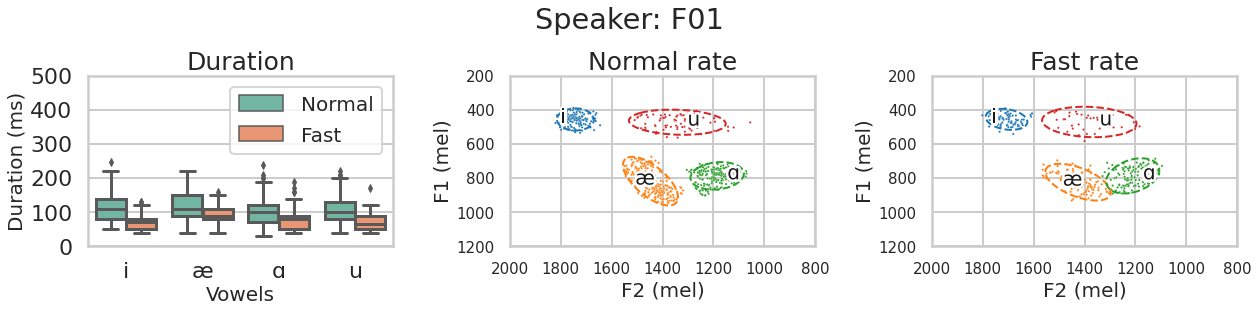

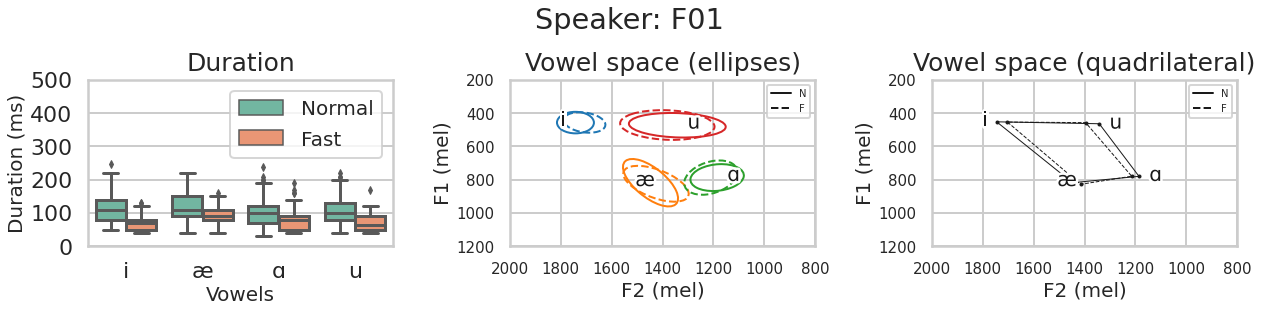

In [12]:
# Plot overall duration and formant patterns for checking
which_spkr = 'F01'
which_time = 0.5
custom_vowels = corner_vowels
# custom_vowels = ["IY1", "IH1", "EH1", "AE1", "AA1", "AH1", "AO1", "UH1", "UW1"]

fig, arr = _plot_dur_vowels(D, which_spkr, which_time, custom_vowels)
fig, arr = _plot_dur_vowel_spaces(D, which_spkr, which_time, custom_vowels)

In [13]:
# custom_vowels = corner_vowels

# for which_spkr in tqdm(spkr_list, total=len(spkr_list)):
#     # Plot
#     with sns.plotting_context(context='poster'):
#         sns.set_style("whitegrid", {'font.family' : 'serif' , 'font.serif' : 'Times New Roman'})
#         #fig, arr = _plot_dur_vowels(D, which_spkr, which_time, custom_vowels)
#         fig, arr = _plot_dur_vowel_spaces(D, which_spkr, which_time, custom_vowels)

#     # Save
#     fig.savefig(os.path.join(plot_dir, f'{which_spkr}_vowel_space.png'), bbox_inches="tight")
#     plt.close()
# del fig, arr
# print('Done')

## COV: coefficients of variation

In [279]:
d = D[['Speaker','Vowel','PreVowelPOA','Rate','F1_mel','F2_mel']].reset_index(drop=True)
d = (d.groupby(['Speaker','Vowel','PreVowelPOA','Rate'])
     .agg(['mean','std'])
     .reset_index()
    )

d['F1_CV'] = d['F1_mel']['std']/d['F1_mel']['mean'] * 100
d['F2_CV'] = d['F2_mel']['std']/d['F2_mel']['mean'] * 100
d = d[['Speaker','Vowel','PreVowelPOA','Rate','F1_CV','F2_CV']].reset_index(drop=True)
d.columns = ['Speaker','Vowel','PreVowelPOA','Rate','F1_CV','F2_CV']

In [280]:
d

,Speaker,Vowel,PreVowelPOA,Rate,F1_CV,F2_CV
0,F01,AA1,alveolar,F,6.858656,3.950194
1,F01,AA1,alveolar,N,4.602402,4.387140
2,F01,AA1,bilabial,F,7.015702,4.797839
3,F01,AA1,bilabial,N,5.801612,3.887132
4,F01,AA1,pharyngeal,F,6.041172,4.116473
...,...,...,...,...,...,...
499,M04,UW1,bilabial,F,5.061026,16.209583
500,M04,UW1,bilabial,N,3.388872,18.491353
501,M04,UW1,pharyngeal,N,0.840096,1.284037
502,M04,UW1,velar,F,7.862818,11.373244


In [275]:
%%R -i d
d$Rate = as.factor(d$Rate)
d$Vowel = as.factor(d$Vowel)
d$Speaker = as.factor(d$Speaker)
d$PreVowelPOA = as.factor(d$PreVowelPOA)

d$Vowel <- ordered(d$Vowel, levels = c("IY1", "IH1", "EH1", "AE1", "AA1", "AH1", "AO1", "UW1"))
d$PreVowelPOA = ordered(d$PreVowelPOA, levels=c("bilabial","alveolar","velar","pharyngeal"))

cov.F1 = lmer(F1_CV ~ Rate*PreVowelPOA*Vowel + (1|Speaker), data=d)
# summary(cov.F1)
Anova(cov.F1, type=3)

Analysis of Deviance Table (Type III Wald chisquare tests)

Response: F1_COV
                          Chisq Df Pr(>Chisq)    
(Intercept)            211.8048  1     <2e-16 ***
Rate                     0.6381  1     0.4244    
PreVowelPOA              3.7666  3     0.2878    
Vowel                   99.8690  7     <2e-16 ***
Rate:PreVowelPOA         0.5760  3     0.9019    
Rate:Vowel               7.1473  7     0.4137    
PreVowelPOA:Vowel       13.3542 21     0.8957    
Rate:PreVowelPOA:Vowel  18.9809 21     0.5864    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [278]:
%%R
cov.F2 = lmer(F2_CV ~ Rate*PreVowelPOA*Vowel + (1|Speaker), data=d)
# summary(cov.F1)
Anova(cov.F2, type=3)

Analysis of Deviance Table (Type III Wald chisquare tests)

Response: F2_COV
                          Chisq Df Pr(>Chisq)    
(Intercept)            338.5232  1  < 2.2e-16 ***
Rate                     0.1532  1    0.69546    
PreVowelPOA              2.3612  3    0.50090    
Vowel                   52.1847  7  5.369e-09 ***
Rate:PreVowelPOA         0.8243  3    0.84363    
Rate:Vowel              12.5663  7    0.08341 .  
PreVowelPOA:Vowel        9.6435 21    0.98318    
Rate:PreVowelPOA:Vowel   5.6663 21    0.99963    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [276]:
# %%R
# em.cov.F1 = emmeans(cov.F1, ~ Vowel, adjust = "tukey")
# pairs(em.cov.F1)

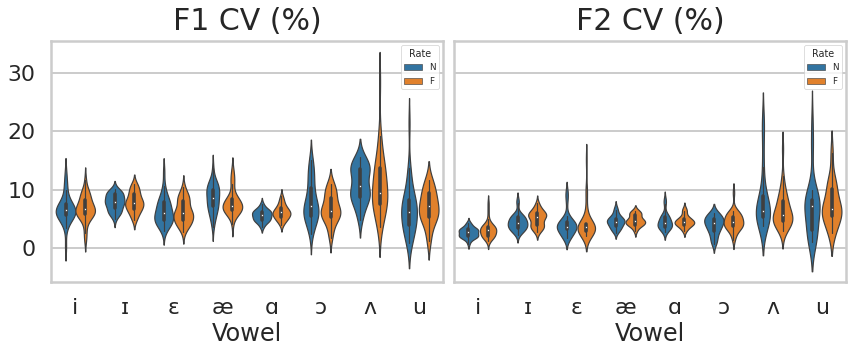

In [281]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), facecolor='white', sharey=True)

with sns.plotting_context('paper'):
    sns.violinplot(ax=ax1, x='Vowel', y='F1_CV', hue='Rate', 
                   order=vowel_list, hue_order=['N','F'], data=d)
    sns.violinplot(ax=ax2, x='Vowel', y='F2_CV', hue='Rate', 
                   order=vowel_list, hue_order=['N','F'], data=d)
    
    ax1.set_title('F1 CV (%)', fontsize=30, y=1.02)
    ax2.set_title('F2 CV (%)', fontsize=30, y=1.02)
    ax1.set_ylabel('')
    ax2.set_ylabel('')
    ax1.set_xticklabels([vowel2ipa[v] for v in vowel_list])
    ax2.set_xticklabels([vowel2ipa[v] for v in vowel_list])
    fig.tight_layout()

## R statistics

In [111]:
%%R -i D
D$Rate = as.factor(D$Rate)
D$Vowel = as.factor(D$Vowel)
D$PreVowel = as.factor(D$PreVowel)
D$Speaker = as.factor(D$Speaker)
D$Block = as.factor(D$Block)
D$Token = as.factor(D$Token)
D$PreVowelPOA = as.factor(D$PreVowelPOA)
D$PostVowelPOA = as.factor(D$PostVowelPOA)

D$Vowel <- ordered(D$Vowel, levels = c("IY1", "IH1", "EH1", "AE1", "AA1", "AH1", "AO1", "UW1"))
D$PreVowelPOA = ordered(D$PreVowelPOA, levels=c("bilabial","alveolar","velar","pharyngeal"))
# str(D)

## DV:F1

In [112]:
%%R
m.F1 = lmer(F1_norm ~ Rate*PreVowelPOA*Vowel + (1|Speaker) + (1|Block), data=D)
summary(m.F1)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: F1_norm ~ Rate * PreVowelPOA * Vowel + (1 | Speaker) + (1 | Block)
   Data: D

REML criterion at convergence: 4501.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8217 -0.6432  0.0222  0.6439  6.0262 

Random effects:
 Groups   Name        Variance  Std.Dev.
 Block    (Intercept) 0.0002179 0.01476 
 Speaker  (Intercept) 0.0017550 0.04189 
 Residual             0.0786753 0.28049 
Number of obs: 13949, groups:  Block, 12; Speaker, 8

Fixed effects:
                              Estimate Std. Error         df t value Pr(>|t|)
(Intercept)                  1.631e-01  1.683e-02  1.098e+01   9.693 1.03e-06
RateN                        3.538e-02  8.374e-03  1.387e+04   4.225 2.40e-05
PreVowelPOA.L               -7.093e-03  1.509e-02  1.387e+04  -0.470 0.638328
PreVowelPOA.Q                2.770e-02  1.350e-02  1.387e+04   2.052 0.040230
PreVowelPOA.C                2.817e-02  1.170e

R[write to console]: 
Correlation matrix not shown by default, as p = 64 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




In [113]:
%%R
# Use anova to assess whether the factor as a whole is explanatory
library(car)
Anova(m.F1, type=3)

Analysis of Deviance Table (Type III Wald chisquare tests)

Response: F1_norm
                            Chisq Df Pr(>Chisq)    
(Intercept)               93.9594  1  < 2.2e-16 ***
Rate                      17.8547  1  2.384e-05 ***
PreVowelPOA                7.7935  3    0.05048 .  
Vowel                  11111.4758  7  < 2.2e-16 ***
Rate:PreVowelPOA           4.8943  3    0.17970    
Rate:Vowel                61.2097  7  8.652e-11 ***
PreVowelPOA:Vowel        138.1901 21  < 2.2e-16 ***
Rate:PreVowelPOA:Vowel    60.5606 21  1.050e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [171]:
%%R
em.F1 = emmeans(m.F1, ~ Rate|Vowel, adjust = "tukey")
pairs(em.F1)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 13949' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 13949)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 13949' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 13949)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions



Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N      0.0521 0.0229 Inf  2.275  0.0229 

Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N     -0.0362 0.0147 Inf -2.462  0.0138 

Vowel = EH1:
 contrast estimate     SE  df z.ratio p.value
 F - N     -0.1139 0.0179 Inf -6.349  <.0001 

Vowel = AE1:
 contrast estimate     SE  df z.ratio p.value
 F - N     -0.1027 0.0135 Inf -7.611  <.0001 

Vowel = AA1:
 contrast estimate     SE  df z.ratio p.value
 F - N     -0.0830 0.0120 Inf -6.895  <.0001 

Vowel = AH1:
 contrast estimate     SE  df z.ratio p.value
 F - N     -0.0413 0.0226 Inf -1.828  0.0675 

Vowel = AO1:
 contrast estimate     SE  df z.ratio p.value
 F - N     -0.0162 0.0200 Inf -0.810  0.4179 

Vowel = UW1:
 contrast estimate     SE  df z.ratio p.value
 F - N      0.0581 0.0466 Inf  1.247  0.2125 

Results are averaged over the levels of: PreVowelPOA 
Degrees-of-freedom method: asymptotic 


In [170]:
%%R
em.F1.poa = emmeans(m.F1, ~ Rate|PreVowelPOA|Vowel, adjust = "tukey")
pairs(em.F1.poa)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 13949' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 13949)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 13949' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 13949)' or larger];
but be warned that this may result in large computation time and memory use.



PreVowelPOA = bilabial, Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N     0.06568 0.0258 Inf  2.550  0.0108 

PreVowelPOA = alveolar, Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N     0.06784 0.0210 Inf  3.229  0.0012 

PreVowelPOA = velar, Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N     0.03409 0.0793 Inf  0.430  0.6674 

PreVowelPOA = pharyngeal, Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N     0.04091 0.0316 Inf  1.294  0.1956 

PreVowelPOA = bilabial, Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.05510 0.0283 Inf -1.947  0.0515 

PreVowelPOA = alveolar, Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.01738 0.0198 Inf -0.878  0.3798 

PreVowelPOA = velar, Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.08720 0.0296 Inf -2.942  0.0033 

PreVowelPOA = pharyngeal, Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N   

In [115]:
# %%R 
# se <- sqrt(diag(vcov(m.F1)))
# # table of estimates with 95% CI
# (tab <- cbind(Est = fixef(m.F1), LL = fixef(m.F1) - 1.96 * se, UL = fixef(m.F1) + 1.96 *se))

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



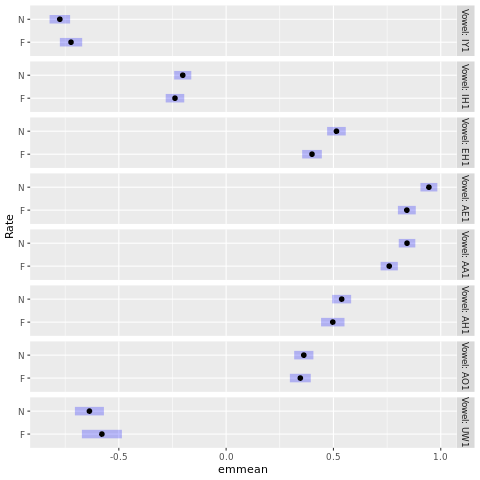

In [172]:
%%R
cex <- 1.5
par(cex.lab=cex, cex.axis=cex, cex.main=cex)
plot(em.F1, by = "Vowel", intervals = TRUE, type = "response")

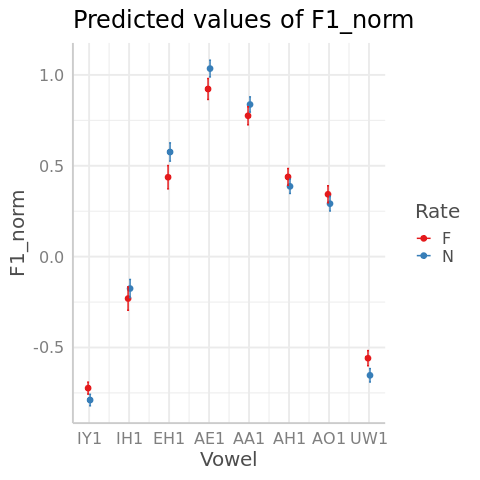

In [173]:
%%R
plot_model(m.F1, type='pred', terms=c("Vowel","Rate"), show.values = TRUE, show.p = TRUE, p.shape = TRUE) +
    theme_sjplot(base_size = 20, base_family = "")

In [162]:
# %%R
# plot_model(m.F1, type = "re")

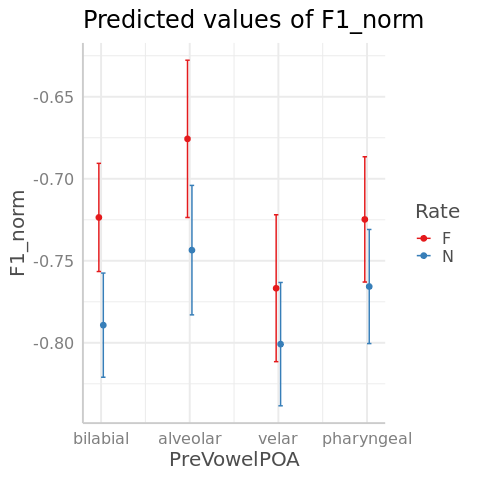

In [148]:
%%R
plot_model(m.F1, type = "pred", terms = c("PreVowelPOA", "Rate"), show.values = TRUE) +
    theme_sjplot(base_size = 20, base_family = "")

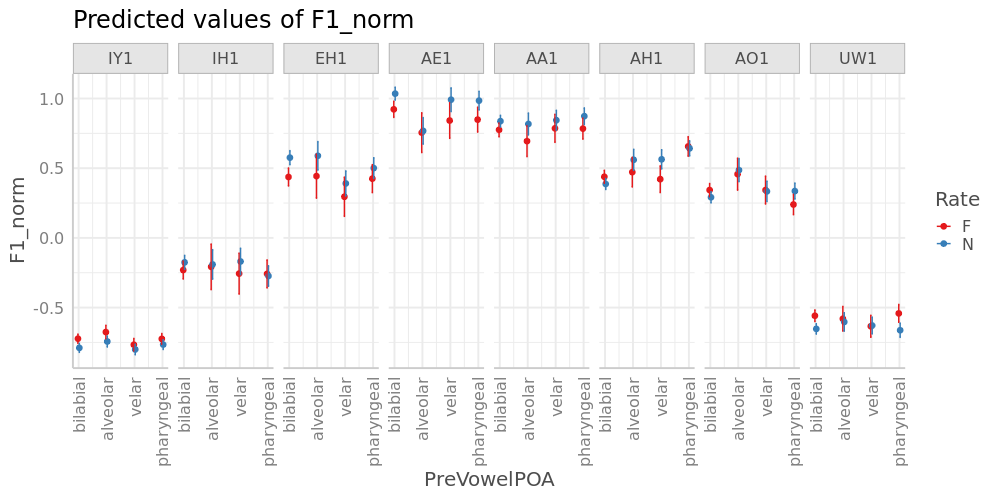

In [149]:
%%R -w 1000 -h 500
plot_model(m.F1, type = "pred", terms = c("PreVowelPOA", "Rate", "Vowel"), show.values = TRUE) +
    facet_wrap(~facet, ncol = 8) +
    theme_sjplot(base_size = 20, base_family = "") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [86]:
# %%R
# bxp <- ggboxplot(
#   D, x = "Vowel", y = "F1_norm",
#   color = "Rate", palette = "jco"
#   )
# bxp

## DV:F2

In [119]:
%%R
m.F2 = lmer(F2_norm ~ Rate*PreVowelPOA*Vowel + (1|Speaker) + (1|Block), data=D)
summary(m.F2)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: F2_norm ~ Rate * PreVowelPOA * Vowel + (1 | Speaker) + (1 | Block)
   Data: D

REML criterion at convergence: 9720.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.2589 -0.6413 -0.0505  0.5643  6.8682 

Random effects:
 Groups   Name        Variance Std.Dev.
 Block    (Intercept) 0.000453 0.02128 
 Speaker  (Intercept) 0.001739 0.04170 
 Residual             0.114569 0.33848 
Number of obs: 13949, groups:  Block, 12; Speaker, 8

Fixed effects:
                              Estimate Std. Error         df t value Pr(>|t|)
(Intercept)                 -2.335e-01  1.793e-02  1.383e+01 -13.024 3.76e-09
RateN                       -3.568e-02  1.011e-02  1.388e+04  -3.530 0.000417
PreVowelPOA.L               -9.734e-03  1.821e-02  1.388e+04  -0.534 0.593033
PreVowelPOA.Q               -1.326e-01  1.630e-02  1.388e+04  -8.137 4.38e-16
PreVowelPOA.C                4.909e-03  1.412e-02 

R[write to console]: 
Correlation matrix not shown by default, as p = 64 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




In [120]:
%%R
# Use anova to assess whether the factor as a whole is explanatory
library(car)
Anova(m.F2, type=3)

Analysis of Deviance Table (Type III Wald chisquare tests)

Response: F2_norm
                            Chisq Df Pr(>Chisq)    
(Intercept)              169.6367  1  < 2.2e-16 ***
Rate                      12.4627  1  0.0004152 ***
PreVowelPOA               98.3854  3  < 2.2e-16 ***
Vowel                  16631.9933  7  < 2.2e-16 ***
Rate:PreVowelPOA           4.4831  3  0.2138062    
Rate:Vowel               306.2566  7  < 2.2e-16 ***
PreVowelPOA:Vowel        186.7583 21  < 2.2e-16 ***
Rate:PreVowelPOA:Vowel    44.5025 21  0.0020119 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [121]:
%%R
em.F2 = emmeans(m.F2, ~ Rate|Vowel, adjust = "tukey")
pairs(em.F2)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 13949' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 13949)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 13949' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 13949)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions



Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.21284 0.0277 Inf -7.697  <.0001 

Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.00548 0.0177 Inf -0.309  0.7572 

Vowel = EH1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.16414 0.0216 Inf -7.582  <.0001 

Vowel = AE1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.02832 0.0163 Inf -1.739  0.0821 

Vowel = AA1:
 contrast estimate     SE  df z.ratio p.value
 F - N     0.13567 0.0145 Inf  9.338  <.0001 

Vowel = AH1:
 contrast estimate     SE  df z.ratio p.value
 F - N     0.08357 0.0273 Inf  3.064  0.0022 

Vowel = AO1:
 contrast estimate     SE  df z.ratio p.value
 F - N     0.21367 0.0241 Inf  8.867  <.0001 

Vowel = UW1:
 contrast estimate     SE  df z.ratio p.value
 F - N     0.26332 0.0562 Inf  4.685  <.0001 

Results are averaged over the levels of: PreVowelPOA 
Degrees-of-freedom method: asymptotic 


In [174]:
%%R
em.F2.poa = emmeans(m.F2, ~ Rate|PreVowelPOA|Vowel, adjust = "tukey")
pairs(em.F2.poa)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 13949' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 13949)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 13949' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 13949)' or larger];
but be warned that this may result in large computation time and memory use.



PreVowelPOA = bilabial, Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.20934 0.0311 Inf -6.736  <.0001 

PreVowelPOA = alveolar, Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.23672 0.0254 Inf -9.336  <.0001 

PreVowelPOA = velar, Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.17129 0.0957 Inf -1.789  0.0736 

PreVowelPOA = pharyngeal, Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.23400 0.0382 Inf -6.133  <.0001 

PreVowelPOA = bilabial, Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N     0.03765 0.0342 Inf  1.102  0.2703 

PreVowelPOA = alveolar, Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.04570 0.0239 Inf -1.914  0.0557 

PreVowelPOA = velar, Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.05999 0.0358 Inf -1.677  0.0935 

PreVowelPOA = pharyngeal, Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N   

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



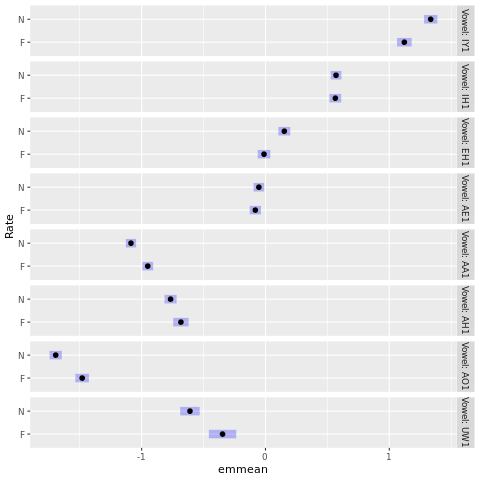

In [122]:
%%R
plot(em.F2, by = "Vowel", intervals = TRUE, type = "response")

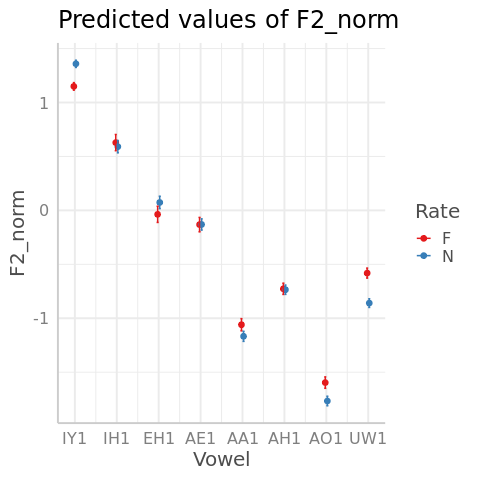

In [123]:
%%R
plot_model(m.F2, type='pred', terms=c("Vowel","Rate")) +
    theme_sjplot(base_size = 20, base_family = "")

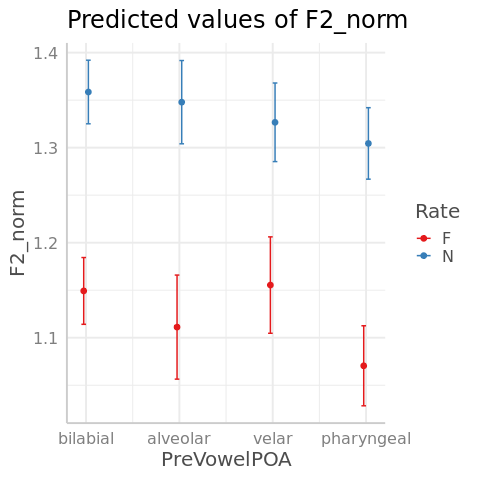

In [124]:
%%R
plot_model(m.F2, type = "pred", terms = c("PreVowelPOA", "Rate")) +
    theme_sjplot(base_size = 20, base_family = "")

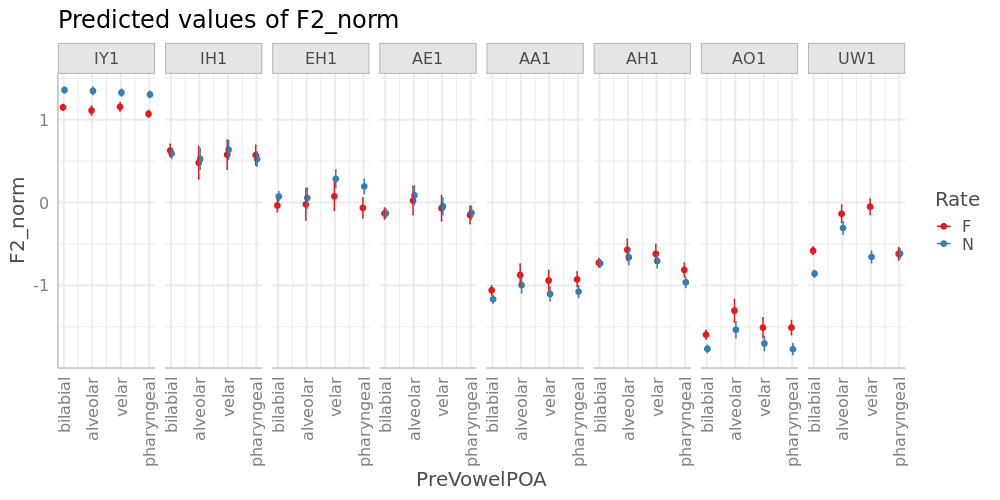

In [163]:
%%R -w 1000 -h 500
plot_model(m.F2, type = "pred", terms = c("PreVowelPOA", "Rate", "Vowel"), show.values = TRUE) +
    facet_wrap(~facet, ncol = 8) +
    theme_sjplot(base_size = 20, base_family = "") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))